<a href="https://colab.research.google.com/github/MaidenTaief/Music_Final/blob/main/Copy_of_Song_RecSys_Content_Collaborative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Collaborative Filtering

###Loading and Preparing Data
First, we set the path to our dataset and load our aggregated data, which includes user IDs and playlist names. This is crucial because we need to know which users interacted with which playlists. We then convert user IDs and playlist names into categorical data types. This conversion helps in indexing and speeds up operations since categorical data uses integers internally, which are faster to process than strings.

To establish a direct mapping between user IDs and their indices in our matrices, as well as between playlist names and their indices, we create two dictionaries: `user_id_to_index` and `playlist_index_to_name`. These mappings are essential for efficiently looking up and referring to specific users and playlists in the subsequent steps.

###Interaction Matrix and Similarity Calculation
We load a pre-saved sparse matrix, `playlist_interaction_matrix`, that represents interactions between users and playlists. Using this matrix, we compute the cosine similarity among users. Cosine similarity helps us understand how similar two users are based on their interactions with various playlists. This similarity metric is a cornerstone of collaborative filtering, allowing us to predict a user's preferences based on the preferences of other similar users.

###Recommendation Function

The `recommend_playlists` function is designed to recommend playlist names to a user based on the preferences of similar users. Here's a breakdown of how this function works:

- **User Index Conversion:** Convert the provided user ID to its corresponding index using the `user_id_to_index` mapping.
- **Similarity Score Retrieval:** Fetch the cosine similarity scores for the given user against all other users.
- **Score Aggregation:** Iterate through each user, weighted by their similarity to the target user, to compile a score for each playlist based on how those similar users interacted with the playlists.
- **Result Compilation:** Zero out scores for playlists the user has already interacted with to ensure we only recommend new content. Then, sort the scores in descending order and pick the top N playlists.

By focusing on playlists favored by users with similar tastes and excluding already familiar content, we can make personalized recommendations that are likely to be of interest.

###Example Usage

To demonstrate the functionality of this system, we use an example user ID and call the `recommend_playlists` function. This example illustrates how you can input any user ID from the dataset and retrieve personalized playlist recommendations.

The output shows the top five recommended playlists for the user, providing a practical example of the recommendation system in action. These recommendations are tailored to the user's inferred preferences, showcasing the effectiveness of collaborative filtering.

In [ ]:
import pandas as pd

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated data
agg_data = pd.read_csv(f'{dataset_path}/aggregated_data.csv')

# Get unique user IDs
unique_user_ids = agg_data['user_id'].unique()

# Print a few example user IDs
print("Example User IDs:", unique_user_ids[:5])  # Adjust the slice as needed to get more or fewer examples


Example User IDs: ['00055176fea33f6e027cd3302289378b' '0007f3dd09c91198371454c608d47f22'
 '000b0f32b5739f052b9d40fcc5c41079' '000c11a16c89aa4b14b328080f5954ee'
 '00123e0f544dee3ab006aa7f1e5725a7']


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import load_npz

def save_user_similarity_matrix(interaction_matrix, path):
    # Calculate cosine similarity matrix
    user_similarity_matrix = cosine_similarity(interaction_matrix, dense_output=True)
    np.save(path, user_similarity_matrix)  # Save the dense matrix
    print("User similarity matrix saved to:", path)

def load_user_similarity_matrix(path):
    try:
        # Load the matrix without allowing pickle to ensure it's not considered an object array
        user_similarity_matrix = np.load(path, allow_pickle=False)
        print("User similarity matrix loaded successfully.")
        print("Shape:", user_similarity_matrix.shape)
        print("Data type:", user_similarity_matrix.dtype)
        return user_similarity_matrix
    except Exception as e:
        print("Failed to load user similarity matrix:", str(e))
        return None

# Set the dataset directory path
dataset_path = '/content/drive/My Drive/DATASET'

# Load the interaction matrix
interaction_matrix_path = f'{dataset_path}/playlist_interaction_sparse_matrix.npz'
interaction_matrix = load_npz(interaction_matrix_path)

# Save the user similarity matrix
similarity_matrix_path = f'{dataset_path}/user_similarity_playlist.npy'
save_user_similarity_matrix(interaction_matrix, similarity_matrix_path)

# Load the user similarity matrix to confirm it's saved correctly
user_similarity_matrix = load_user_similarity_matrix(similarity_matrix_path)


User similarity matrix saved to: /content/drive/My Drive/DATASET/user_similarity_playlist.npy
User similarity matrix loaded successfully.
Shape: (15201, 15201)
Data type: float64


In [ ]:
from scipy.sparse import load_npz

# Function to load and inspect the interaction matrix
def inspect_interaction_matrix(path):
    # Load the interaction matrix from the specified path
    interaction_matrix = load_npz(path)

    # Display properties of the interaction matrix
    print("Interaction matrix loaded from:", path)
    print("Shape:", interaction_matrix.shape)
    print("Data type:", interaction_matrix.dtype)
    print("Number of non-zero entries:", interaction_matrix.nnz)
    print("Density of the matrix: {:.6f}".format(interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1])))

    return interaction_matrix

# Set the dataset directory path
dataset_path = '/content/drive/My Drive/DATASET'
interaction_matrix_path = f'{dataset_path}/playlist_interaction_sparse_matrix.npz'

# Load and inspect the interaction matrix
interaction_matrix = inspect_interaction_matrix(interaction_matrix_path)

Interaction matrix loaded from: /content/drive/My Drive/DATASET/playlist_interaction_sparse_matrix.npz
Shape: (15201, 99153)
Data type: int64
Number of non-zero entries: 154834
Density of the matrix: 0.000103


In [ ]:
import numpy as np
import pickle
from scipy.sparse import load_npz

def recommend_playlists(user_id, user_similarity_matrix, interaction_matrix, user_id_to_index, playlist_index_to_name, top_n=10):
    if user_id not in user_id_to_index:
        return "User ID not found."

    user_index = user_id_to_index[user_id]
    if user_index >= user_similarity_matrix.shape[0]:
        return "User index is out of bounds for the similarity matrix."

    similarity_scores = user_similarity_matrix[user_index]
    similar_indices = np.argsort(-similarity_scores)[:top_n+1]
    similar_indices = similar_indices[similar_indices != user_index]

    playlist_scores = np.zeros(interaction_matrix.shape[1])
    for idx in similar_indices:
        playlist_scores += interaction_matrix[idx].toarray().flatten() * similarity_scores[idx]

    user_playlists = interaction_matrix[user_index].nonzero()[1]
    playlist_scores[user_playlists] = 0
    top_playlist_indices = np.argsort(-playlist_scores)[:top_n]
    recommended_playlists = [playlist_index_to_name[idx] for idx in top_playlist_indices]

    return recommended_playlists

# Load necessary data
dataset_path = '/content/drive/My Drive/DATASET'
with open(f'{dataset_path}/user_id_to_index.pkl', 'rb') as f:
    user_id_to_index = pickle.load(f)
with open(f'{dataset_path}/index_to_playlist_name.pkl', 'rb') as f:
    playlist_index_to_name = pickle.load(f)
user_similarity_matrix = np.load(f'{dataset_path}/user_similarity_playlist.npy')
playlist_interaction_matrix = load_npz(f'{dataset_path}/playlist_interaction_sparse_matrix.npz')

# Test the function
example_user_id = '00055176fea33f6e027cd3302289378b'
recommended_playlists = recommend_playlists(example_user_id, user_similarity_matrix, playlist_interaction_matrix, user_id_to_index, playlist_index_to_name)
print("Recommended Playlists:", recommended_playlists)

Recommended Playlists: ['J. Period & Black Thought - The Best of The Roots', '00-nek-en_el_cuarto_26-sp-2007', 'ONLY DURAN DURAN', "Elvis 75 - Good Rockin' Tonight", 'Great Dane – Alpha Dog', '60´s 4 eva', '#facebookdown', 'Led Zeppelin – How The West Was Won', 'Easy Listening Blues', 'Kensington – Vultures - Festival Edition']


##Hybrid Filtering

###Setting Up the Environment
First off, we specify the location of our dataset and load it into our environment. This dataset includes both user IDs and playlist names, along with additional cluster information that we'll use later for content-based filtering. By converting user IDs and playlist names to categorical data types, we optimize the indexing process which is essential for handling large datasets efficiently.

We also establish mappings for both user IDs and playlist names to numerical indices. These mappings are critical because they allow us to efficiently access and manipulate our data structures, especially when working with matrices.

###Interaction Matrix and Similarity Computation

Next, we load a pre-computed sparse matrix, `playlist_interaction_matrix`, that captures the interactions between users and playlists. This matrix is fundamental to calculating the cosine similarity among users, which we perform next. Cosine similarity measures how similar the interaction patterns of different users are, and it's a key component of collaborative filtering. This similarity helps us identify users with similar tastes and preferences.

###Hybrid Recommendation Function

The function `hybrid_recommend_playlists` is designed to leverage both collaborative and content-based filtering for recommending playlists:

- **Collaborative Filtering**: We use the computed user similarity scores to identify users with similar playlist interaction patterns to the target user. By aggregating the interaction data from these similar users, we can predict which playlists might interest the target user.

- **Content-Based Filtering**: We enhance our recommendations by considering the 'cluster' attribute of playlists. Playlists within the same cluster likely share certain characteristics or themes. By boosting the scores of playlists within the same cluster as those the user has shown interest in, we refine our recommendations to be more tailored and relevant.

Each playlist's score is adjusted based on its cluster's relation to the user's preferences, ensuring that recommended playlists are not just popular among similar users but also contextually relevant.



###Setup and Data Preparation
We start by setting the location of our dataset and loading the song data that includes important cluster information. This data is crucial as it contains the interactions between users and songs, which are fundamental to understanding user preferences.

To efficiently handle and reference the song data, we convert song names into categorical data types. This not only optimizes our operations but also allows us to effectively index songs, which is essential for the recommendation process.

By creating mappings from song names to indices, we ensure quick and direct access to song data throughout our recommendation computations, enhancing the system’s efficiency.

###Dimensionality Reduction with Truncated SVD
To manage the potentially large and sparse song interaction matrix, we apply Truncated SVD (Singular Value Decomposition). This method reduces the dimensionality of our dataset while preserving its significant characteristics. Here, we choose 200 components, a number that balances complexity and performance, making our dataset more manageable and speeding up subsequent calculations.

Reducing dimensions helps in mitigating issues like overfitting and computational overload, especially when dealing with large datasets. It also aids in extracting the latent factors that represent underlying patterns in song interactions.

###Our recommendation function, `Hybrid_recommend_songs`, combines collaborative filtering and content-based filtering techniques:

- **Collaborative Filtering**: We calculate the cosine similarity between the target song vector (from our reduced matrix) and all other song vectors. This metric helps us find songs that share similar interaction patterns, suggesting that users who liked one may like the others.

- **Content-Based Filtering**: We enhance our recommendations using the cluster information from the songs. Songs within the same cluster typically share thematic or stylistic similarities. We give a higher weight to songs from the same cluster as the target song, refining our recommendations to be contextually relevant.

The function fetches additional candidates to ensure robust filtering and then ranks these songs based on their computed similarity scores, adjusted for content relevance.



In [ ]:
import pandas as pd

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated data
agg_data = pd.read_csv(f'{dataset_path}/aggregated_data.csv')

# Get unique user IDs
unique_song_name = agg_data['name'].unique()

# Print a few example user IDs
print("Example song names:", unique_song_name[:5])  # Adjust the slice as needed to get more or fewer examples


Example song names: ['18' '21 Guns' 'A Little Too Much' 'Act My Age' 'After Midnight']


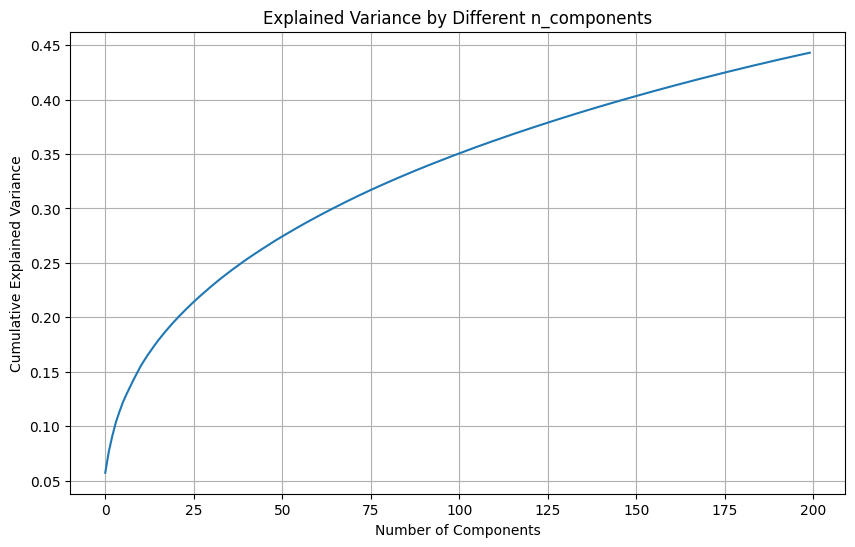

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=200)
reduced_matrix = svd.fit_transform(song_interaction_matrix)

# Plotting explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different n_components')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated song data
song_data = pd.read_csv(f'{dataset_path}/aggregated_data_full.csv')

# Filter songs by the artist "The Weeknd", handling potential case variations
weeknd_songs = song_data[song_data['artistname'].str.lower() == '2Pac']

# Display the song names
print("Songs by The Weeknd:")
print(weeknd_songs['trackname'].unique())


Songs by The Weeknd:
[]


In [5]:
import pandas as pd
from scipy.sparse import csr_matrix, load_npz
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated song data
song_data = pd.read_csv(f'{dataset_path}/aggregated_data_full.csv')
song_data['trackname'] = song_data['trackname'].str.lower().str.strip()
song_data.drop_duplicates(subset=['trackname'], inplace=True)  # Ensure no duplicate songs

# After modifying DataFrame, rebuild index to keep it consistent
song_data.reset_index(drop=True, inplace=True)
# Convert 'trackname' to categorical after making sure it's cleaned and unique
song_data['trackname'] = pd.Categorical(song_data['trackname'])
song_name_to_index = {name: index for index, name in enumerate(song_data['trackname'].cat.categories)}

# Load the interaction matrix for songs
song_interaction_matrix = load_npz(f'{dataset_path}/sparse_song_matrix.npz')

# Applying Truncated SVD to reduce dimensions
svd = TruncatedSVD(n_components=100)
reduced_matrix = svd.fit_transform(song_interaction_matrix.transpose())

def hybrid_recommend_songs(song_name, song_name_to_index, reduced_matrix, song_data, top_n=5):
    song_name_processed = song_name.lower().strip()
    if song_name_processed not in song_name_to_index:
        return ["Song not found."]
    song_index = song_name_to_index[song_name_processed]
    target_song_vector = reduced_matrix[song_index]
    similarity_scores = cosine_similarity([target_song_vector], reduced_matrix)[0]

    enhanced_scores = []
    target_genres = set(song_data.at[song_index, 'genres'].split(','))
    for idx, score in enumerate(similarity_scores):
        if idx != song_index and idx < len(song_data):
            song_meta = song_data.iloc[idx]
            score_adjustment = score

            # More weight to genre and cluster similarity
            if song_data.at[song_index, 'cluster'] == song_meta['cluster']:
                score_adjustment *= 1.5  # Strong emphasis on same cluster

            # Check if any genre matches, and if so, give a significant boost
            current_genres = set(song_meta['genres'].split(','))
            if current_genres & target_genres:
                score_adjustment *= 2  # Double the score if genres match

            # Less weight to popularity and year
            if song_data.at[song_index, 'popularity'] == song_meta['popularity']:
                score_adjustment *= 1.1  # Smaller boost for popularity match
            year_difference = abs(song_data.at[song_index, 'year'] - song_meta['year'])
            score_adjustment *= 1 / (1 + 0.01 * year_difference)  # Small decrease based on year difference

            enhanced_scores.append((score_adjustment, idx))

    recommended_indices = sorted(enhanced_scores, reverse=True, key=lambda x: x[0])[:top_n]
    recommended_songs = [(song_data.iloc[i]['trackname'], song_data.iloc[i]['artistname'], song_data.iloc[i]['genres']) for _, i in recommended_indices]

    return recommended_songs

# Example usage
input_song_name = 'Precious Love'
recommended_songs = hybrid_recommend_songs(input_song_name, song_name_to_index, reduced_matrix, song_data, top_n=5)
print(f"Recommended Songs for '{input_song_name}':")
for song, artist, genres in recommended_songs:
    print(f"Song: {song}, Artist: {artist}, Genres: {genres}")


Recommended Songs for 'Precious Love':
Song: digging your scene, Artist: the blow monkeys, Genres: dance rock / new romantic / new wave / new wave pop / sophisti-pop / synthpop
Song: protection, Artist: massive attack, Genres: Unknown
Song: million dollar bash, Artist: bob dylan, Genres: classic rock / country rock / folk / folk rock / rock / roots rock / singer-songwriter
Song: act of affection, Artist: wailing souls, Genres: dub / lovers rock / old school dancehall / reggae / rock steady / roots reggae / ska
Song: mind, Artist: talking heads, Genres: art punk / art rock / dance rock / funk rock / new wave / permanent wave / post-punk / rock / zolo


In [ ]:
# List of songs to check
songs_to_check = [
    "flight of the order of the phoenix",
    "if you see me",
    "brenda's got a baby",
    "tin tin por tin tin",
    "contigo aprendí"
]

# Convert track names in the database to lower case for case-insensitive matching
song_data['trackname'] = song_data['trackname'].str.lower()

# Filter the DataFrame to find rows where the track name is in the songs_to_check list
filtered_data = song_data[song_data['trackname'].isin(songs_to_check)]

# Select only the relevant columns to display
result = filtered_data[['trackname', 'artistname', 'genres']]

# Print the results
print(result)


In [6]:
import pandas as pd
import joblib
from scipy.sparse import save_npz
import pickle

# Save the DataFrame
song_data.to_pickle('/content/drive/My Drive/DATASET/song_data.pkl')

# Save the dictionary using joblib
joblib.dump(song_name_to_index, '/content/drive/My Drive/DATASET/song_name_to_index.joblib')

# pickle for dictionaries:
with open('/content/drive/My Drive/DATASET/song_name_to_index.pickle', 'wb') as handle:
    pickle.dump(song_name_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Save the interaction matrix
save_npz('/content/drive/My Drive/DATASET/song_interaction_matrix.npz', song_interaction_matrix)

# Save the reduced matrix from SVD
np.save('/content/drive/My Drive/DATASET/reduced_matrix.npy', reduced_matrix)
